# Kernel methods

The aim of this project is to improve the accuracy of the SVM (support vector machine) model. This issue has been treated by Chris J.C. Burges and Bernhard Schölkopf in their paper “Improving the Accuracy and Speed ofSupport Vector Machines”, available [at this link](https://papers.nips.cc/paper/1253-improving-the-accuracy-and-speed-of-support-vector-machines.pdf). Whereas they evoke both accuracy and speed improvement, we will only focus on accuracy for this project. 

## Library importation

* time: basic time-related functions
* numpy: using mathematical tools on matrix
* pandas: data analysis and manipulation tool
* matplotlib.pyplot: ploting graphs to represent data
* accuracy_score from sklearn.metrics: measure the accuracy of a model
* SVC from sklearn.svm: perform Support Vector classification

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

## Dataset preparation

Firstly, we read csv files containing training and testing datasets. They are both stored in the data folder. The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. It contains 60,000 training images and 10,000 testing images, explained by 784 variables (28x28 pixels). Each row is labelled from 0 to 9 which represents the number they actually depicts.

In [2]:
train = pd.read_csv('data/mnist_train.csv', header=None) # train set
test = pd.read_csv('data/mnist_test.csv', header=None) # test set
train.shape

(60000, 785)

We separate the variables from their labels in both training and testing sets. Variables are normalized by dividing them by the maximum RVB value which is 255. 

Then, we reshape our training data to obtain a visualizable dataset representing 60,000 2D-images of 28x28 pixels and we plot the first one. 

(60000, 28, 28)


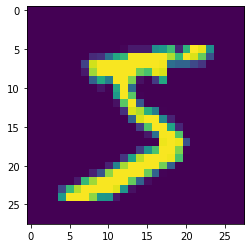

In [3]:
max_rgb = 255
X_train, y_train = train.drop([0], axis=1) / max_rgb, train[0] # scaling
X_test, y_test = test.drop([0], axis=1) / max_rgb, test[0]
dim = int(np.sqrt(X_train.shape[-1]))
X_train_image = X_train.values.reshape(-1, dim, dim) # reshaping for plotting
print(X_train_image.shape)
plt.imshow(X_train_image[0])
plt.show()

## Naive method

Now that we have a prepared dataset, we can perform the support vector classification. We begin with the naive method that consists of using a polynomial kernel of degree 5 and a regularized parameter of 10. We fit this model with our training data, and store the resulting support vectors and their index.

In [4]:
C, kernel, deg, = 10, 'poly', 5
svc = SVC(C=C, kernel=kernel, degree=deg)
svc.fit(X_train, y_train) # naive training
sv_label = y_train[svc.support_] # extraction of the labels corresponding to support vectors
sv = svc.support_vectors_ # extraction of support vectors
sv.shape

(8269, 784)

Lastly, we measure the prediction time and the accuracy. 

In [5]:
start_time = time.time()
pred = svc.predict(X_test) # naive prediction
naive_time = time.time() - start_time # speed comparaison
naive_accuracy = accuracy_score(y_test, pred) # accuracy comparaison
print("--- %s seconds ---" % naive_time)
print(naive_accuracy)

--- 78.70577096939087 seconds ---
0.9667


The prediction takes some time (more than 1 minute) and reveals an accuracy score of 96.67%. Even if it is already precise, we want to improve this accuracy.

## Accuracy improvement

We will apply the method described in the paper to improve the model accuracy. The first step is to start from the support vectors computed with the naive Support Vector Machine. It is important to remind here what support vectors are. Support vectors are the vectors of data whith which the result will be the same if we remove all the other vectors.

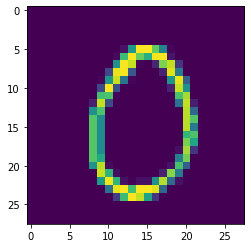

In [6]:
sv_image = sv.reshape(-1, dim, dim) # reshaping for plotting
plt.imshow(sv_image[0])
plt.show()

The methods in the paper involves the artificial creation of a virtual training dataset from the original support vector. Indeed, building the new training set by extending the support vectors instead of the original training set enables an efficient reduction of the number of samples which is critical for the speed of the training. These virtual dataset is generated by extending the support vectors through invariance transformations. Here, the invariance transformation are the shifting of the image represented by the supports vectors respectively to the right, left, down and up. We can visualize this shift by plotting the corresponding images.

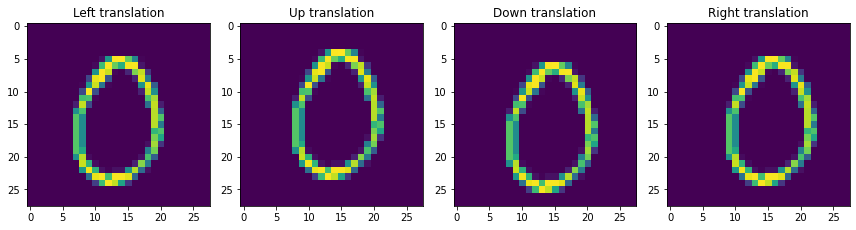

In [7]:
offset = 1 # number of pixels for the shift
sv_right = np.zeros((sv.shape[0], dim, dim))
sv_right[:,:,offset:dim] = sv_image[:,:,0:dim-offset] # right shift
sv_left = np.zeros((sv.shape[0], dim, dim))
sv_left[:,:,0:dim-offset] = sv_image[:,:,offset:dim] # left shift
sv_down = np.zeros((sv.shape[0], dim, dim))
sv_down[:,offset:dim,:] = sv_image[:,0:dim-offset,:] # down shift
sv_up = np.zeros((sv.shape[0], dim, dim))
sv_up[:,0:dim-offset,:] = sv_image[:,offset:dim,:] # up shift
fig, axs = plt.subplots(1, 4, tight_layout=True) # plotting the shifted images
fig.set_size_inches(12, 12)
axs[0].imshow(X=sv_left[0])
axs[0].set_title('Left translation')
axs[1].imshow(X=sv_up[0])
axs[1].set_title('Up translation')
axs[2].imshow(X=sv_down[0])
axs[2].set_title('Down translation')
axs[3].imshow(X=sv_right[0])
axs[3].set_title('Right translation')
plt.show() # draw plot

Finally, we gather the 4 sets of transformed support vectors to create a new virtual traning set. It is reshaped to be trainable. Along these virtual features, we have to create a virtual label set from the original training set in order to match the dimension since it is now the equivalent of 4 sets of the original support vectors. Then, we train the same SVC mode as above on the virtual datas.

In [8]:
X_train_virtual = np.concatenate((sv_right, sv_left, sv_up, sv_down), axis=0) # creation of the virual training set
X_train_virtual = X_train_virtual.reshape(X_train_virtual.shape[0], -1) # reshaping for training
y_train_virtual = np.tile(sv_label, 4) # creation of the virtual label set for training
svc.fit(X_train_virtual, y_train_virtual) # improved training

SVC(C=10, degree=5, kernel='poly')

We evaluate the speed and accuracy of this new model. 

In [9]:
start_time = time.time()
pred = svc.predict(X_test) # improved prediction
improved_time = time.time() - start_time # predic
improved_accuracy = accuracy_score(y_test, pred) # accuracy score
print("--- %s seconds ---" % improved_time)
print(improved_accuracy)

--- 204.35500383377075 seconds ---
0.9782


We compare the speed and accuracy of the 2 models. Intuitively, we expect to get a more accurate but a slower a prediction.

In [10]:
print("accuracy improvement: %s" % ((improved_accuracy - naive_accuracy)*100))
print("speed: %f times longer" % (improved_time/naive_time))

accuracy improvement: 1.1499999999999955
speed: 2.596442 times longer


## Speed improvement

We did not address it, but the paper also deals with speed reduction, as the virtual support vectors model increases a lot prediction speed. The paper suggests to create a reduced set of minimal size, such that any resulting loss in accuracy remains acceptable. This dimension reduction can be performed with methods such as PCA, PCR, LDA or QDA. 

## Conclusion

By creating 4 sets of virtual support vectors, we succeeded in improving the accuracy of 1.15%. We have pratically shown  that the method illustrated in the paper is more accurate than a "classical" SVM.